# 1.Spotting Most important features

In [1]:
# %matplotlib inline

import xgboost as xgb
import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.5)

In [2]:
dtrain = xgb.DMatrix('./resources/agaricus.txt.train')
dtest = xgb.DMatrix('./resources/agaricus.txt.test')

In [3]:
# specify training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [4]:
# see how does it perform
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11049	train-error:0.113926
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487


### Representation of a tree
Before moving on it's good to understand the intuition about how trees are grown.

> *While building a tree is divided recursively several times (in this example only once) - this operation is called **split**. To perform a split the algorithm must figure out which is the best (one) feature to use*.

> *After that, at the bottom of the we get groups of observations packed in the **leaves**.*

> *In the final model, these leafs are supposed to be **as pure as possible** for each tree, meaning in our case that each leaf should be made of one label class.*

> *Not all splits are equally important. Basically the first split of a tree will have more impact on the purity that, for instance, the deepest split. Intuitively, we understand that the first split makes most of the work, and the following splits focus on smaller parts of the dataset which have been missclassified by the first tree.*

> *In the same way, in Boosting we try to optimize the missclassification at each round (it is called the loss). So the first tree will do the big work and the following trees will focus on the remaining, on the parts not correctly learned by the previous trees.*

> *The improvement brought by each split can be measured, it is the gain.*

> ~ Quoted from the Kaggle Tianqi Chen's Kaggle [notebook](https://www.kaggle.com/tqchen/otto-group-product-classification-challenge/understanding-xgboost-model-on-otto-data).

Let's investigate how trees look like on our case:

In [5]:
trees_dump = bst.get_dump(fmap='./resources/featmap.txt', with_stats=True)

for tree in trees_dump:
    print(tree)

0:[odor=pungent] yes=2,no=1,gain=4000.53,cover=1628.25
	1:leaf=0.647758,cover=924.5
	2:leaf=-0.93331,cover=703.75

0:[odor=musty] yes=2,no=1,gain=1377.22,cover=1404.2
	1:leaf=-0.339609,cover=1008.21
	2:leaf=0.75969,cover=395.989

0:[gill-size=narrow] yes=2,no=1,gain=1210.77,cover=1232.64
	1:leaf=0.673358,cover=430.293
	2:leaf=-0.365203,cover=802.35

0:[stalk-surface-above-ring=smooth] yes=2,no=1,gain=791.959,cover=1111.84
	1:leaf=-0.277529,cover=765.906
	2:leaf=0.632881,cover=345.937

0:[odor=pungent] yes=2,no=1,gain=493.704,cover=981.683
	1:leaf=0.275961,cover=638.373
	2:leaf=-0.46668,cover=343.31



For each split we are getting the following details:

- which feature was used to make split,
- possible choices to make (branches)
- **gain** which is the actual improvement in accuracy brough by that feature. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite),
- **cover** measuring the relative quantity of observations concerned by that feature



### Plotting
Hopefully there are better ways to figure out which features really matter. We can use built-in function `plot_importance` that will create a plot presenting most important features due to some criterias. We will analyze the impact of each feature for all splits and all trees and visualize results.

See which feature provided the most gain:

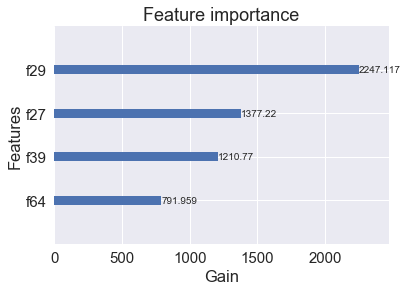

In [6]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain');

We can simplify it a little bit by introducing a *F-score* metric.

> **F-score** - sums up how many times a split was performed on each feature. 

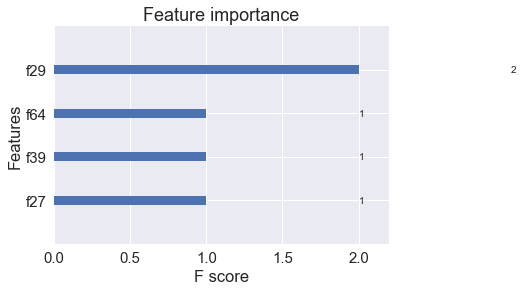

In [7]:
xgb.plot_importance(bst);

In [8]:
importances = bst.get_fscore()
importances

{'f29': 2, 'f27': 1, 'f39': 1, 'f64': 1}

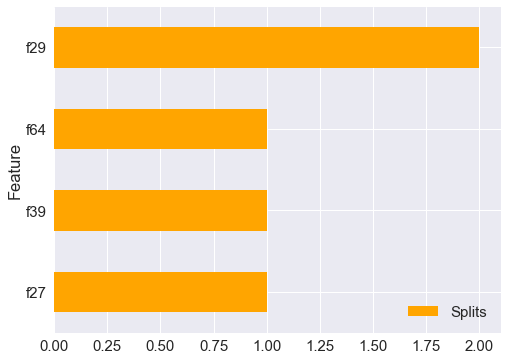

In [9]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange');

# 2. Bias/variance trade-off

The following notebook presents visual explanation about how to deal with bias/variance trade-off, which is common machine learning problem.
<br/><br/>



### Bias and variance<a name='biasvariance' />
There are two general types of errors made by classifiers - bias and variance errors.

> **Bias error** is the overall difference between expected predictions made by the model and true values.
>
> **Variance error** describes how much predictions for the given point vary.

The desired state is when both errors are as low as possible. The graphics taken from [Scott Fortmann-Roe's blog](http://scott.fortmann-roe.com/docs/BiasVariance.html) visualizes the issue really well. Imagine that the center of the target is the perfect model. We are iteratively repeating our experiment, recreating model and using it on the same data points.

<img src='./resources/bias-variance.png' width="500px" height="500px" />

### Underfitting and overfitting<a name='fitting' />
Knowing the errors introduced with bias and variance we can proceed to how these relate to training the model. We will use the plot taken from scikit-learn [docs](http://www.astroml.org/sklearn_tutorial/practical.html) to help us visualize the **underfitting** and **overfitting** issues.
<img src='./resources/underfitting_overfitting.png' />
This simple example tries to fit a polynomial regression to predict future price. It's obious to see that for $d=1$ the model is too simple (underfits the data), and for $d=6$ is just the opposite (overfitting).

> For **underfitting** we say that model suffers from *high bias* (too simple) (low variance)
>
> For **overfitting** we say that model suffers from *high variance* (over-complicated, unstable) (low bias)

### How to detect it<a name='detect' />
To quantify the effects described we are going to train the model couple times for choosing different parameters value. Let's consider that we would like to find a optimal number of trees - we don't want the model to be very simple, but we also don't want to over-complicate it.

The plan is as follows, we will:

- generate complicated binary classification dataset,
- use Scikit-learn wrapper,
- train the model for different values of trees (`n_estimators)`) using stratified 10-fold CV,
- plot train/test errors

Begin with loading required libraries and setting random seed number

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.cross_validation import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

# reproducibility
seed = 123
np.random.seed(seed)

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [11]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=seed)

In [12]:
# Divide into 10 stratified folds 
# (the same distibution of labels in each fold) for testing
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

In [13]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
);

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

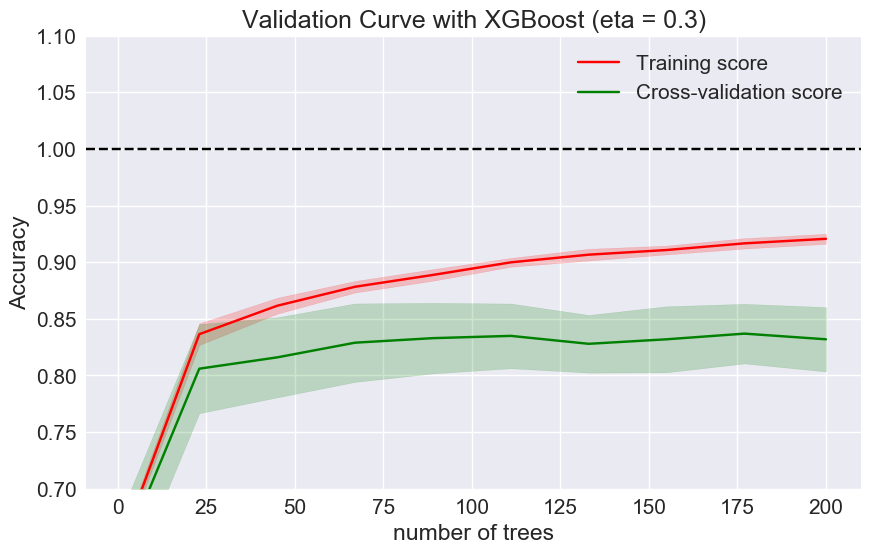

Best cross-validation result (0.84) obtained for 177 trees


In [14]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(
    n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range,
    test_scores_mean,
    label="Cross-validation score",
    color="g")

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r")

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
    test_scores_mean[i], n_estimators_range[i]))

Looking at the plot we can draw the following conclusions:

- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees,
- from about 25 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity

We can assume that the trade-off for our model will be met at `n_estimators = 50`. The variance is still to big.

### What we can do?<a name='deal' />

#### Dealing with high variance
If model is too complex try:
- using less features (ie. feature selection),
- using more training samples (ie. artificially generated),
- increasing regularization (add penalties for extra complexity)

In XGBoost you can try to:
- reduce depth of each tree (`max_depth`),
- increase `min_child_weight` parameter,
- increase `gamma` parameter,
- add more randomness using `subsample`, `colsample_bytree` parameters,
- increase `lambda` and `alpha` regularization parameters

#### Dealing with high bias
If model is too simple:
- add more features (ie. better feature engineering),
- more sophisticated model
- decrease regularization

In XGBoost you can do it by:
- increase depth of each tree (`max_depth`),
- decrease `min_child_weight` parameter,
- decrease `gamma` parameter,
- decrease `lambda` and `alpha` regularization parameters

Let's try to tweak a parameters a little bit. We are going to add some randomness - each tree we will use 70% randomly chosen samples and 60% randomly chosen features. This should help to reduce a variance. To decrease the bias (bigger accuracy) try adding an extra level to each tree.

In [15]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 3, # changed
    'learning_rate': 0.3,
    'silent': 1.0,
    'colsample_bytree': 0.7, # added
    'subsample': 0.8 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)



/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


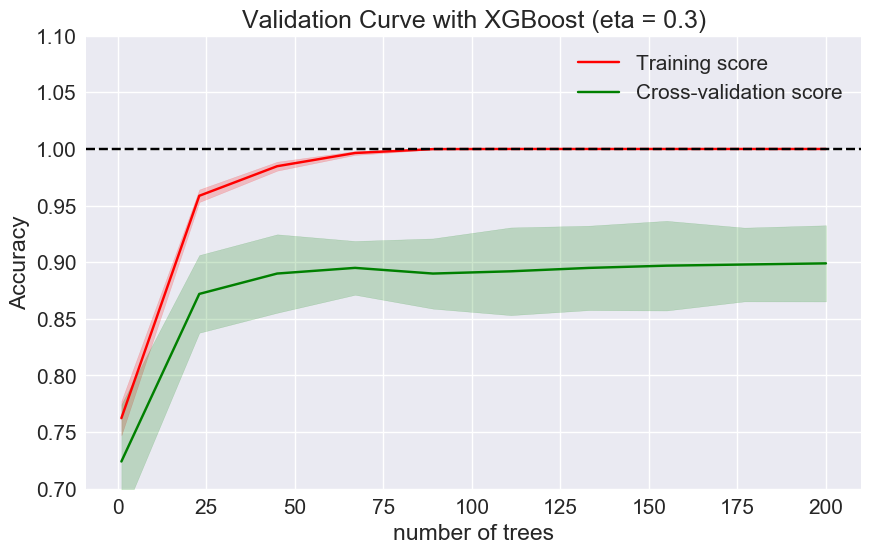

Best cross-validation result (0.90) obtained for 200 trees


In [16]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(
    n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range,
    test_scores_mean,
    label="Cross-validation score",
    color="g")

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r")

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
    test_scores_mean[i], n_estimators_range[i]))

# 3. Hyper-parameter tuning

As you know there are plenty of tunable parameters. Each one results in different output. The question is which combination results in best output.

The following notebook will show you how to use Scikit-learn modules for figuring out the best parameters for your  models.

In [17]:
import numpy as np

from xgboost.sklearn import XGBClassifier

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold

from scipy.stats import randint, uniform

# reproducibility
seed = 342
np.random.seed(seed)

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=seed)

Define cross-validation strategy for testing. Let's use `StratifiedKFold` which guarantees that target label is equally distributed across each fold:

In [19]:
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

### Grid-Search<a name='grid' />
In grid-search we start by defining a dictionary holding possible parameter values we want to test. **All** combinations will be evaluted.

In [20]:
params_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

In [21]:
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [22]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)

Before running the calculations notice that $3*4*3*10=360$ models will be created to test all combinations. You should always have rough estimations about what is going to happen.

In [23]:
bst_grid.fit(X, y)

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ... 0 1], n_folds=10, shuffle=True, random_state=342),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=342, silent=1,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 10, 25, 50], 'learning_rate': array([1.e-16, 5.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ... 0 1], n_folds=10, shuffle=True, random_state=342),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=342, silent=1,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 10, 25, 50], 'learning_rate': array([1.e-16, 5.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

Now, we can look at all obtained scores, and try to manually see what matters and what not. A quick glance looks that the largeer `n_estimators` then the accuracy is higher.

In [24]:
bst_grid.grid_scores_

[mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 1, 'n_estimators': 5},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 1, 'n_estimators': 10},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 1, 'n_estimators': 25},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 1, 'n_estimators': 50},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 2, 'n_estimators': 5},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 2, 'n_estimators': 10},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 2, 'n_estimators': 25},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 2, 'n_estimators': 50},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 3, 'n_estimators': 5},
 mean: 0.50400, std: 0.00200, params: {'learning_rate': 1e-16, 'max_depth': 3, 'n_estimators': 10},
 me

In [25]:
# If there are many results, we can filter them manually to get the best combination
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.872
Parameters:
	learning_rate: 0.5
	max_depth: 3
	n_estimators: 50


### Randomized Grid-Search<a name='rgrid' />
When the number of parameters and their values is getting big traditional grid-search approach quickly becomes ineffective. A possible solution might be to randomly pick certain parameters from their distribution. While it's not an exhaustive solution, it's worth giving a shot.

Create a parameters distribution dictionary:

In [26]:
params_dist_grid = {
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform() # gaussian distribution
}

Initialize `RandomizedSearchCV` to **randomly pick 10 combinations of parameters**. With this approach you can easily control the number of tested models.

In [27]:
rs_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    random_state=seed
)

In [28]:
rs_grid.fit(X, y)
rs_grid.grid_scores_

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

[mean: 0.71000, std: 0.02691, params: {'colsample_bytree': 0.06503439684192913, 'gamma': 0, 'learning_rate': 0.82231421953113, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.11676744056370758},
 mean: 0.83600, std: 0.02911, params: {'colsample_bytree': 0.11848249237448605, 'gamma': 1, 'learning_rate': 0.13214054942810016, 'max_depth': 1, 'n_estimators': 689, 'subsample': 0.4325346125891868},
 mean: 0.77800, std: 0.02574, params: {'colsample_bytree': 0.37621772642449514, 'gamma': 0, 'learning_rate': 0.610870226429942, 'max_depth': 4, 'n_estimators': 392, 'subsample': 0.1523931947190449},
 mean: 0.81500, std: 0.03653, params: {'colsample_bytree': 0.20992824607318106, 'gamma': 1, 'learning_rate': 0.4089849433509952, 'max_depth': 1, 'n_estimators': 574, 'subsample': 0.7099300190073073},
 mean: 0.84300, std: 0.03280, params: {'colsample_bytree': 0.22187963515640408, 'gamma': 1, 'learning_rate': 0.829247179484142, 'max_depth': 2, 'n_estimators': 116, 'subsample': 0.936106086335447},
 me

In [29]:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8058014316376573, gamma=0,
       learning_rate=0.4636309538821305, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=281, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=342, silent=1,
       subsample=0.7652628330253548)

In [30]:
rs_grid.best_params_

{'colsample_bytree': 0.8058014316376573,
 'gamma': 0,
 'learning_rate': 0.4636309538821305,
 'max_depth': 4,
 'n_estimators': 281,
 'subsample': 0.7652628330253548}

In [31]:
rs_grid.best_score_

0.877

# 4. Evaluation
In this notebook you will see how measure the quality of the algorithm performance.

In [32]:
import numpy as np
import xgboost as xgb

from pprint import pprint

# reproducibility
seed = 123
np.random.seed(seed)

In [33]:
# load Agaricus data
dtrain = xgb.DMatrix('./resources/agaricus.txt.train')
dtest = xgb.DMatrix('./resources/agaricus.txt.test')

In [34]:
# specify general training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [35]:
watchlist  = [(dtest,'test'), (dtrain,'train')]

### Using predefined evaluation metrics<a name='pmetrics' />

#### What is already available?
There are already [some](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) predefined metrics availabe. You can use them as the input for the `eval_metric` parameter while training the model.

- `rmse` - [root mean square error](https://www.wikiwand.com/en/Root-mean-square_deviation),
- `mae` - [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error?oldformat=true),
- `logloss` - [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function?oldformat=true)
- `error` - binary classification error rate. It is calculated as `#(wrong cases)/#(all cases)`. Treat predicted values with probability $p > 0.5$ as positive,
- `merror` - multiclass classification error rate. It is calculated as `#(wrong cases)/#(all cases)`,
- `auc` - [area under curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic?oldformat=true),
- `ndcg` - [normalized discounted cumulative gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain?oldformat=true),
- `map` - [mean average precision](https://en.wikipedia.org/wiki/Information_retrieval?oldformat=true)

By default an `error` metric will be used.

In [36]:
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11049	train-error:0.113926
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487


In [37]:
params['eval_metric'] = 'logloss'
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-logloss:0.457887	train-logloss:0.460108
[1]	test-logloss:0.383911	train-logloss:0.378728
[2]	test-logloss:0.312678	train-logloss:0.308061
[3]	test-logloss:0.26912	train-logloss:0.26139
[4]	test-logloss:0.239746	train-logloss:0.232174


You can also use multiple evaluation metrics at one time

In [38]:
params['eval_metric'] = ['logloss', 'auc']
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-logloss:0.457887	test-auc:0.892138	train-logloss:0.460108	train-auc:0.888997
[1]	test-logloss:0.383911	test-auc:0.938901	train-logloss:0.378728	train-auc:0.942881
[2]	test-logloss:0.312678	test-auc:0.976157	train-logloss:0.308061	train-auc:0.981415
[3]	test-logloss:0.26912	test-auc:0.979685	train-logloss:0.26139	train-auc:0.985158
[4]	test-logloss:0.239746	test-auc:0.9785	train-logloss:0.232174	train-auc:0.983744


### Creating custom evaluation metric<a name='cmetrics' />

In order to create our own evaluation metric, the only thing needed to do is to create a method taking two arguments - predicted probabilities and `DMatrix` object holding training data.

In this example our classification metric will simply count the number of misclassified examples assuming that classes with $p> 0.5$ are positive. You can change this threshold if you want more certainty. 

The algorithm is getting better when the number of misclassified examples is getting lower. Remember to also set the argument `maximize=False` while training.

In [39]:
# custom evaluation metric
def misclassified(pred_probs, dtrain):
    labels = dtrain.get_label()  # obtain true labels
    preds = pred_probs > 0.5  # obtain predicted values
    return 'misclassified', np.sum(labels != preds)

In [40]:
bst = xgb.train(
    params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False)

[0]	test-logloss:0.457887	test-auc:0.892138	train-logloss:0.460108	train-auc:0.888997	test-misclassified:178	train-misclassified:742
[1]	test-logloss:0.383911	test-auc:0.938901	train-logloss:0.378728	train-auc:0.942881	test-misclassified:178	train-misclassified:742
[2]	test-logloss:0.312678	test-auc:0.976157	train-logloss:0.308061	train-auc:0.981415	test-misclassified:54	train-misclassified:198
[3]	test-logloss:0.26912	test-auc:0.979685	train-logloss:0.26139	train-auc:0.985158	test-misclassified:44	train-misclassified:140
[4]	test-logloss:0.239746	test-auc:0.9785	train-logloss:0.232174	train-auc:0.983744	test-misclassified:50	train-misclassified:166


### Extracting the evaluation results
You can get evaluation scores by declaring a dictionary for holding values and passing it as a parameter for `evals_result` argument.

In [41]:
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_rounds,
    watchlist,
    feval=misclassified,
    maximize=False,
    evals_result=evals_result)

[0]	test-logloss:0.457887	test-auc:0.892138	train-logloss:0.460108	train-auc:0.888997	test-misclassified:178	train-misclassified:742
[1]	test-logloss:0.383911	test-auc:0.938901	train-logloss:0.378728	train-auc:0.942881	test-misclassified:178	train-misclassified:742
[2]	test-logloss:0.312678	test-auc:0.976157	train-logloss:0.308061	train-auc:0.981415	test-misclassified:54	train-misclassified:198
[3]	test-logloss:0.26912	test-auc:0.979685	train-logloss:0.26139	train-auc:0.985158	test-misclassified:44	train-misclassified:140
[4]	test-logloss:0.239746	test-auc:0.9785	train-logloss:0.232174	train-auc:0.983744	test-misclassified:50	train-misclassified:166


In [42]:
pprint(evals_result)

{'test': {'auc': [0.892138, 0.938901, 0.976157, 0.979685, 0.9785],
          'logloss': [0.457887, 0.383911, 0.312678, 0.26912, 0.239746],
          'misclassified': [178.0, 178.0, 54.0, 44.0, 50.0]},
 'train': {'auc': [0.888997, 0.942881, 0.981415, 0.985158, 0.983744],
           'logloss': [0.460108, 0.378728, 0.308061, 0.26139, 0.232174],
           'misclassified': [742.0, 742.0, 198.0, 140.0, 166.0]}}


### Early stopping<a name='earlystopping' />
There is a nice optimization trick when fitting multiple trees. 

You can train the model until the validation score **stops** improving. Validation error needs to decrease at least every `early_stopping_rounds` to continue training. This approach results in simpler model, because the lowest number of trees will be found (simplicity).

In the following example a total number of 1500 trees is to be created, but we are telling it to stop if the validation score does not improve for last ten iterations.

In [43]:
params['eval_metric'] = 'error'
num_rounds = 1500

bst = xgb.train(
    params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

[0]	test-error:0.11049	train-error:0.113926
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487
[5]	test-error:0.019243	train-error:0.01735
[6]	test-error:0.019243	train-error:0.01735
[7]	test-error:0.015518	train-error:0.013358
[8]	test-error:0.015518	train-error:0.013358
[9]	test-error:0.009311	train-error:0.007523
[10]	test-error:0.015518	train-error:0.013358
[11]	test-error:0.019243	train-error:0.01735
[12]	test-error:0.009311	train-error:0.007523
[13]	test-error:0.001862	train-error:0.001996
[14]	test-error:0.005587	train-error:0.005988
[15]	test-error:0.005587	train-error:0.005988
[16]	test-error:0.005587	train-error:0.005988
[17]	test-error:0.005587	train-error:0.005988
[18]	test-error:0.005587	train-error:0.00

When using `early_stopping_rounds` parameter resulting model will have 3 additional fields - `bst.best_score`, `bst.best_iteration` and `bst.best_ntree_limit`.

In [44]:
print("Booster best train score: {}".format(bst.best_score))
print("Booster best iteration: {}".format(bst.best_iteration))
print("Booster best number of trees limit: {}".format(bst.best_ntree_limit))

Booster best train score: 0.001996
Booster best iteration: 13
Booster best number of trees limit: 14


Also keep in mind that `train()` will return a model from the last iteration, not the best one.

### Cross validating results<a name='cv' />
Native package provides an option for cross-validating results (but not as sophisticated as Sklearn package). The next input shows a basic execution. Notice that we are passing only single `DMatrix`, so it would be good to merge train and test into one object to have more training samples.

In [45]:
num_rounds = 10  # how many estimators
hist = xgb.cv(
    params, dtrain, num_rounds, nfold=10, metrics={'error'}, seed=seed)
hist

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.113924,0.013314,0.113926,0.001479
1,0.113924,0.013314,0.113926,0.001479
2,0.030401,0.005700,0.030401,0.000633
3,0.021495,0.005275,0.021496,0.000586
4,0.025487,0.005459,0.025488,0.000606
5,0.020728,0.007625,0.019687,0.003490
6,0.017350,0.003366,0.017350,0.000374
7,0.015353,0.003696,0.014467,0.001922
8,0.013358,0.003764,0.013358,0.000418
9,0.012590,0.004698,0.011737,0.003818


Notice that:

- by default we get a pandas data frame object (can be changed with `as_pandas` param),
- metrics are passed as an argument (muliple values are allowed),
- we can use own evaluation metrics (param `feval` and `maximize`),
- we can use early stopping feature (param `early_stopping_rounds`)

# 5. Deal with missing values
The following notebook demonstrate XGBoost resilience to missing values. Two approaches - native interface, and Sklearn wrapper were tested against missing datasets.

Missing value is commonly seen in real-world data sets. Handling missing values has no rule to apply to all cases, since there could be various reasons for the values to be missing.

In [46]:
import numpy as np
import xgboost as xgb

from xgboost.sklearn import XGBClassifier

from sklearn.cross_validation import cross_val_score

# reproducibility
seed = 123

Let's prepare a valid dataset with no missing values. There are 10 samples, each one will contain 5 randomly generated features and will be assigned to one of two classes.

In [47]:
# create valid dataset
np.random.seed(seed)

data_v = np.random.rand(10,5) # 10 entities, each contains 5 features
data_v

array([[0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897],
       [0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]])

In the second example we are going to add some missing values

In [48]:
# add some missing values
data_m = np.copy(data_v)

data_m[2, 3] = np.nan
data_m[0, 1] = np.nan
data_m[0, 2] = np.nan
data_m[1, 0] = np.nan
data_m[4, 4] = np.nan
data_m[7, 2] = np.nan
data_m[9, 1] = np.nan

data_m

array([[0.69646919,        nan,        nan, 0.55131477, 0.71946897],
       [       nan, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224,        nan, 0.39804426],
       [0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759],
       [0.63440096, 0.84943179, 0.72445532, 0.61102351,        nan],
       [0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612],
       [0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029],
       [0.31226122, 0.42635131,        nan, 0.94416002, 0.50183668],
       [0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916],
       [0.25045537,        nan, 0.98555979, 0.51948512, 0.61289453]])

Also generate target variables. Each sample will be assigned to one of two classes - so we are dealing with binary classification problem

In [49]:
np.random.seed(seed)

label = np.random.randint(2, size=10) # binary target
label

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

### Native interface<a name='native' />
In this case we will check how does the native interface handles missing data. Begin with specifing default parameters.

In [50]:
# specify general training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [51]:
# In the experiment first we will create a valid `DMatrix` 
# (with all values), see if it works ok, and then repeat the 
# process with lacking one.
dtrain_v = xgb.DMatrix(data_v, label=label)

In [52]:
xgb.cv(params, dtrain_v, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.305556,0.274986,0.301587,0.118783
1,0.305556,0.274986,0.301587,0.118783
2,0.305556,0.274986,0.301587,0.118783
3,0.305556,0.274986,0.301587,0.118783
4,0.305556,0.274986,0.301587,0.118783


The output obviously doesn't make sense, because the data is completely random.

When creating `DMatrix` holding missing values we have to explicitly tell what denotes that it's missing. Sometimes it might be `0`, `999` or others. In our case it's Numpy's `NAN`. Add `missing` argument to `DMatrix` constructor to handle it.

In [53]:
dtrain_m = xgb.DMatrix(data_m, label=label, missing=np.nan)

In [54]:
# Cross-validate results:
xgb.cv(params, dtrain_m, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.305556,0.274986,0.301587,0.118783
1,0.305556,0.274986,0.301587,0.118783
2,0.305556,0.274986,0.301587,0.118783
3,0.305556,0.274986,0.301587,0.118783
4,0.305556,0.274986,0.301587,0.118783


It looks like the algorithm works also with missing values.

In XGBoost chooses a soft way to handle missing values. 

When using a feature with missing values to do splitting, XGBoost will assign a direction to the missing values instead of a numerical value. 

Specifically, XGBoost guides all the data points with missing values to the left and right respectively, then choose the direction with a higher gain with regard to the objective.

### Sklearn wrapper<a name='sklearn' />
The following section shows how to validate the same behaviour using Sklearn interface.

Begin with defining parameters and creating an estimator object.

In [55]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.5,
    'silent': 1.0,
    'n_estimators': 5
}

In [56]:
clf = XGBClassifier(**params)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=1.0, subsample=1)

Cross-validate results with full dataset. Because we have only 10 samples, we will perform 2-fold CV.

In [57]:
cross_val_score(clf, data_v, label, cv=2, scoring='accuracy')

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0.66666667, 0.75      ])

Some score was obtained, we won't dig into it's interpretation.

See if things work also with missing values

In [58]:
cross_val_score(clf, data_m, label, cv=2, scoring='accuracy')

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0.66666667, 0.75      ])

Both methods works with missing datasets. The Sklearn package by default handles data with `np.nan` as missing (so you will need additional pre-precessing if using different convention).

# Handle Imbalanced Dataset

There are plenty of examples in real-world problems that deals with imbalanced target classes. Imagine medical data where there are only a few positive instances out of thousands of negatie (normal) ones. Another example might be analyzing fraud transaction, in which the actual frauds represent only a fraction of all available data.

> Imbalanced data refers to a classification problems where the classes are not equally distributed.

You can read good introduction about tackling imbalanced datasets [here](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

### General advices<a name='generaladvices' />
These are some common tactics when approaching imbalanced datasets:

- collect more data,
- use better evaluation metric (that notices mistakes - ie. AUC, F1, Kappa, ...),
- try oversampling minority class or undersampling majority class,
- generate artificial samples of minority class (ie. SMOTE algorithm)

In XGBoost you can try to:
- make sure that parameter `min_child_weight` is small (because leaf nodes can have smaller size groups), it is set to `min_child_weight=1` by default,
- assign more weights to specific samples while initalizing `DMatrix`,
- control the balance of positive and negative weights  using `set_pos_weight` parameter,
- use AUC for evaluation

In [59]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split

# reproducibility
seed = 123

We'll use a function to generate dataset for binary classification. To assure that it's imbalanced use `weights` parameter. In this case there will be 200 samples each described by 5 features, but only 10% of them (about 20 samples) will be positive. That makes the problem harder.

In [60]:
X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=3,
    n_classes=2,
    weights=[.9, .1],
    shuffle=True,
    random_state=seed
)

print('There are {} positive instances.'.format(y.sum()))

There are 20 positive instances.


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=seed)

print('Total number of postivie train instances: {}'.format(y_train.sum()))
print('Total number of positive test instances: {}'.format(y_test.sum()))

Total number of postivie train instances: 13
Total number of positive test instances: 7


### Baseline model
In this approach try to completely ignore the fact that classed are imbalanced and see how it will perform. Create `DMatrix` for train and test data.

In [62]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [63]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 15

In [64]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [65]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,58,1,59
1,5,2,7
All,63,3,66


We can also present the performance using 3 different evaluation metrics:
- [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), 
- [precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) (the ability of the classifier not to label as positive a sample that is negative),
- [recall](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) (the ability of the classifier to find all the positive samples). 

In [66]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.67
Recall: 0.29


Intuitively we know that the foucs should be on finding positive samples. First results are very promising (94% accuracy - wow), but deeper analysis show that the results are biased towards majority class - we are very poor at predicting the actual label of positive instances. That is called an [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox?oldformat=true).

### Custom weights<a name='custom_weights' />
Try to explicitly tell the algorithm what important using relative instance weights. Let's specify that positive instances have 5x more weight and add this information while creating `DMatrix`.

In [67]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added
dtest = xgb.DMatrix(X_test)

In [68]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [69]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,57,2,59
1,4,3,7
All,61,5,66


In [70]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.43


### Use `scale_pos_weight` parameter<a name='scaleposweight' />
You can automate the process of assigning weights manually by calculating the proportion between negative and positive instances and setting it to `scale_pos_weight` parameter.

Let's reinitialize datasets.

In [71]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

Calculate the ratio between both classes and assign it to a parameter.

In [72]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [73]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,4,3,7
All,60,6,66


In [74]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.89
Precision: 0.50
Recall: 0.43


You can see that scalling weight by using `scale_pos_weights` in this case gives better results that doing it manually. We are now able to perfectly classify all posivie classes (focusing on the real problem). On the other hand the classifier sometimes makes a mistake by wrongly classifing the negative case into positive (producing so called *false positives*).